## Specify Inputs

In [110]:
#Define Batches
batches = "UCB007|UCB008[A-B]|UCB009|UCB010"
batches = "UCB008C|UCB009AM"
batches = "UCB008CF"
batches = "UCB008C"

# Define Unit Cells in ML
Layers = 11 # Number of unit cells in each MultiSlayer pouch

# Specify any defective/cracked cells to flag and remove from pairing
DefectiveCells = ['UCB007AA-US00-110', 'UCB007AA-US00-101',
                  'UCB008AA-US00-19', 'UCB008AA-US00-24', 'UCB008AA-US00-44'] 

#Specify any missing cells to flag and remove from pairing
MissingCells = ["UCB004AH-US00-18", "UCB004AH-US00-61", 
                 "UCB005AB-US01-02", "UCB005AC-US00-46", "UCB005AG-US01-17", "UCB005AH-US01-24", "UCB005AP-US00-04", "UCB005AS-US00-08", "UCB005AW-US00-31",'UCB005AY-US00-02', "UCB005AZ-US00-23", 
                 "UCB005AM-US00-11", "UCD015AJ-US00-12", "UCD011AR-US00-03", "UCD015AC-US01-07", "UCD014AA-US00-20", "UCD011AP-US00-16", "UCD011AZ-US00-10", "UCD011BB-US00-37", "UCD011BB-US00-42",
                 "UCB005BD-US00-11", "UCB005BD-US00-25", "UCB005BD-US00-31", "UCB005BD-US00-30", "UCB005BD-US00-32", "UCB005BJ-US00-09", "UCB005BN-US00-03", "UCB005BR-US00-44", "UCB005BQ-US00-18",
                 "CPD021FC-US00-18", "CPD021FD-US00-07", "CPD021FD-US00-16", "CPD021GE-US00-19", "CPD021GF-US00-17", "CPD023BC-US00-04", "CPD023BC-US00-05", "CPD021GJ-US00-09", "CPD021GJ-US00-17",
                 "CPD023AR-US01-08", "CPD023AS-US01-13", "CPD023AQ-US01-13", "CPD023AQ-US00-19", "CPD023AW-US00-04", "CPD023AX-US00-12", "CPD023AX-US00-19", "CPD023AY-US00-05", "CPD023AY-US00-12", "CPD023AY-US00-16", 
                 "CPD023BA-US00-21", "CPD023BA-US00-08",
                 "UCB005BA-US00-02", "UCB005BC-US00-35", "UCB005BD-US00-09", "UCB005BD-US00-37", "UCB005BE-US00-01", "UCB005BE-US00-21", "UCB005BE-US00-34", "UCB005BG-US00-11", "UCB005BG-US00-41"] #these cells have an edge case in alignment and will need to be paired seperately

BadFTF = ['UCB007AA-US00-65', 'UCB007AA-US00-78']

#Tier and pair specific cells (CustomList) instead of batches
UseCustomList = 0 #needs to be 1 to only Tier and Pair the listed cells below
#This is the list of specific cells you want to Tier and Pair

CustomList = ['UCB008AA-US00-23', 'UCB008AA-US00-38', 'UCB008AA-US00-04',  'UCB008AA-US00-07', 'UCB008AA-US00-39']

#Cell Status Settings
ShowOnlyYield = 1 #Only Group/Pair cells that yielded according to datahub, change this variable to pair "non-yielded" cells as well 
GroupWaitingOnly = 1 #Only Group/Pair cells that have a cell status of "Waiting", needs to be 1 to only pair "Waiting" cells 
#Grouping Criteria
ASR_range_limit = 2.0   #threshold for ASR range in ML (usually 2.0)
ASR_mean_min_limit= 0.5 # threshold for ASR mean-min in ML (usually 0.5)
max_attempts = 10   # how many times the pairing loop will run before giving up. It will reorder the remaining cells by ASR instead of Rank after max_attempts/2, increase this number if you still see possible groups in the "Remainder" cells

## Import Modules and Functions

In [111]:
#import modules used in this script
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
from qsdc.client import Client
#import functions used in this script
import query_tray_samples_V4 as query_tray_samples
from matplotlib.ticker import PercentFormatter


#assert version("qs-data-client") >= "0.2.15", "qsdc version must be greater than 0.2.15"

#Remove warning messages
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
#establish clients 
qs_client = Client()
conn = qs_client.get_mysql_engine()


## Pull Cell Data From Datahub

In [112]:
## Query Data from Datahub

#Pull cell metrology data from datahub, both standard/auto metrology and manual review
dfctq = qs_client.data_hub.get_dataset(dataset = 'MFG-60L-UC-CTQ') ## standard metro review of unit cells
#dfmr = qs_client.data_hub.get_dataset(dataset = 'MFG-60L-UC-MR') ## manual review of unit cells

#Pull geneology/multilayer info
dmlg = qs_client.data_hub.get_dataset(dataset = 'MFG-80L-ML-PRODUCTION') ##multilayer info (ML_id)
dmlg = dmlg.dropna(subset="US_id").drop_duplicates()
#dgen = qs_client.data_hub.get_dataset(dataset = 'MFG-MASTER-GENEALOGY') ##multilayer info (ML_id)
danc = qs_client.data_hub.get_dataset("MFG-UNIT-CELL-ANCESTRY")

#Pull Cathode Mass data
cathode_mass = qs_client.data_hub.get_dataset("MFG-50L-CATHODE-CTQ")
cathode_mass = cathode_mass[["PU_id", "cathode_dry_mass"]]
danc = danc[["US_id","PU_id"]].dropna(subset="US_id").drop_duplicates()
danc = danc.merge(cathode_mass, on = "PU_id", how = "left").sort_values(["US_id"])
danc = danc.rename(columns={'US_id': 'US_ID'}) 


#Pull cell electrical test data
dfc = qs_client.data_hub.get_dataset(dataset = 'MFG-60L-UNIT-CELL-TEST-CYCLE') ##electrical test data of unit cells
cols = [
    "US_id",
    "TestCycleStart_datetime_first",
    "TestCycleStart_datetime",
    "UCT_Version",
    "idtest_recipe",
    "RunIndex",
    "CycleIndex",
    "dvdt",
    "recipe_dvdt_range",
    "CeilingHoldTime",
    "CE",
    "CapacityChargeFraction",
    "CeilingRestVoltage",
    "AMSDcCapacity",
    "CycleFailure",
    "AnyFailure",
    "MedDcASR",
    "DischargeCapacity"
]

#Filter datahub rows by batches 
if UseCustomList != 1:
    # Keep cells from batches of interest and remove those that failed screening
    filtered_dfctq = dfctq[dfctq['US_id'].str.contains(batches, na=False)] #keep cells that are from the batches of interest
    #filtered_dfmr = dfmr[dfmr['US_id'].str.contains(batches, na=False)] #keep only cells that are from the batches of interest
    dfc = dfc[dfc['US_id'].str.contains(batches, na=False)].sort_values(["RunIndex","CycleIndex"])[cols]
    if ShowOnlyYield == 1:
        yielded_dfctq = filtered_dfctq[filtered_dfctq['unit_cell_test_yield'] == 1] #keep cells that yielded
        #yielded_dfmr = filtered_dfmr[filtered_dfmr['unit_cell_test_yield'] == 1] #keep cells that yielded
    else:
        yielded_dfctq = filtered_dfctq
        #yielded_dfmr = filtered_dfmr

#Filter datahub rows by custom list
if UseCustomList == 1:
    yielded_dfctq = dfctq[dfctq['US_id'].isin(CustomList)]
    #yielded_dfmr = dfmr[dfmr['US_id'].isin(CustomList)]
    #dfc = dfc[dfc['US_id'].isin(CustomList)][cols]
    batches = "CustomList"
    

c:\Users\EDM02\AppData\Local\Programs\Python\Python39\lib\site-packages\qsdc\datahub\datahub.py:88: DtypeWarning: Columns (15,39) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(bytesIO(blob_bytes))


## Generate Cell Status/Tier Spreadsheet

### Combine Metro and Electrical Data and Tier Unit Cells

In [113]:
# Step 1: Copy original metro data
dfctq_updated = yielded_dfctq.copy()

# Step 2: clean up electrical data, aggregate last non-missing values for each US_id
def last_non_missing(series):
    return series.dropna().iloc[-1] if not series.dropna().empty else None

dfc_consolidated = (
    dfc.groupby('US_id', as_index=False)
       .agg({
           'MedDcASR': last_non_missing,
           'DischargeCapacity': last_non_missing
       })
       .rename(columns={
           'US_id': 'Cell ID',
           'MedDcASR': 'MedDischargeASR_1C',
           'DischargeCapacity': 'DischargeCapacity_Co3'
       })
)

# Step 3: Merge electrical metrics into main dataframe, combine top and bottom anode tiering into one column
CellTiering = pd.merge(
    dfctq_updated,
    dfc_consolidated,
    left_on='US_id',
    right_on='Cell ID',
    how='left'
)
CellTiering['Anode'] = CellTiering[['A1_anode_tier_top_us', 'A1_anode_tier_bottom_us']].max(axis=1)

# Step 4: Define Tier logic based on actual metrics
conditions = [
    # Tier 1
    (CellTiering['Anode'] == 1) &
    (CellTiering['cathode_alignment_custom_model_tier_us'] == 1) &
    (CellTiering['median_contour_catholyte_pct_us'] > 98) &
    (CellTiering['center_normalized_0_5mm_eroded_rect_outside_median_us'] < 1.045) &
    (CellTiering['MedDischargeASR_1C'] > 17.2) &
    (CellTiering['MedDischargeASR_1C'] < 18.6),

    # Tier 2
    (CellTiering['Anode'] == 1) &
    (CellTiering['cathode_alignment_custom_model_tier_us'] == 1) &
    (CellTiering['median_contour_catholyte_pct_us'] > 98) &
    (CellTiering['center_normalized_0_5mm_eroded_rect_outside_median_us'] < 1.045) &
    (CellTiering['MedDischargeASR_1C'] > 18.6) &
    (CellTiering['MedDischargeASR_1C'] < 21.0),

    # Tier 3
    (CellTiering['Anode'] == 1) &
    (CellTiering['cathode_alignment_custom_model_tier_us'] == 1) &
    (CellTiering['median_contour_catholyte_pct_us'] > 98) &
    (CellTiering['center_normalized_0_5mm_eroded_rect_outside_median_us'] >= 1.045) &
    (CellTiering['center_normalized_0_5mm_eroded_rect_outside_median_us'] < 1.1) &
    (CellTiering['MedDischargeASR_1C'] > 17.2) &
    (CellTiering['MedDischargeASR_1C'] < 21.0),

    # Tier 4
    (CellTiering['Anode'] == 1) &
    (CellTiering['cathode_alignment_custom_model_tier_us'] == 1) &
    (CellTiering['MedDischargeASR_1C'] > 17.2) &
    (CellTiering['MedDischargeASR_1C'] < 21.0) &
    (
        (CellTiering['center_normalized_0_5mm_eroded_rect_outside_median_us'] >= 1.1) |
        (CellTiering['median_contour_catholyte_pct_us'] <= 98)
    ),

    # Spec Fail
    (CellTiering['MedDischargeASR_1C'] > 17.2) &
    (CellTiering['MedDischargeASR_1C'] < 21.0) &
    (
        (CellTiering['Anode'] > 1) |
        (CellTiering['cathode_alignment_custom_model_tier_us'] > 1)
    ),

    # Low ASR Fail
    (CellTiering['MedDischargeASR_1C'] < 17.2),

    #High ASR Fail
    (CellTiering['MedDischargeASR_1C'] > 21.0),

    # Missing Matrix and TCDS
    CellTiering[[
        'cathode_alignment_custom_model_tier_us',
        'median_contour_catholyte_pct_us',
    ]].isna().any(axis=1) &
    CellTiering[[
        'A1_anode_tier_top_us',
        'A1_anode_tier_bottom_us',
        'center_normalized_0_5mm_eroded_rect_outside_median_us',
    ]].isna().any(axis=1),

    # Missing TCDS
    CellTiering[[
        'A1_anode_tier_top_us',
        'A1_anode_tier_bottom_us',
        'center_normalized_0_5mm_eroded_rect_outside_median_us',
    ]].isna().any(axis=1),

    # Missing Matrix
    CellTiering[[
        'cathode_alignment_custom_model_tier_us',
        'median_contour_catholyte_pct_us',
    ]].isna().any(axis=1),
]


choices = ['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4', 'Spec Fail', 'Low ASR Fail', 'High ASR Fail', 'Missing Matrix and TCDS', 'Missing TCDS', 'Missing Matrix']
CellTiering['Tier'] = np.select(conditions, choices, default='Unclassified')



#Step 5: Rename columns and keep the ones of interest
CellTiering['Cell Status'] = 'Unpaired'
CellTiering = CellTiering.rename(columns={
    'cathode_alignment_custom_model_tier_us': 'Alignment',
    'center_normalized_0_5mm_eroded_rect_outside_median_us': 'Thickness',
    'median_contour_catholyte_pct_us': 'Edge Wetting',
    'MedDischargeASR_1C': 'Discharge ASR',
    'DischargeCapacity_Co3':'Discharge Capacity',
    'max_f2f_distance_us':'F2F Distance'
})

CellTiering['Thickness'] = CellTiering['Thickness'].round(5)
CellTiering['Discharge ASR'] = CellTiering['Discharge ASR'].round(2)
CellTiering['Discharge Capacity'] = CellTiering['Discharge Capacity'].round(2)
CellTiering = CellTiering[['Cell ID', 'Tier', 'Anode', 'Alignment', 'Thickness', 'Edge Wetting', 'Discharge ASR', 'Discharge Capacity', 'F2F Distance', 'Cell Status']]


#Sort CellTiering by "Cell ID"
# Extract prefix and numeric suffix
CellTiering['prefix'] = CellTiering['Cell ID'].str.extract(r'^(.*)-\d+$')[0]
CellTiering['suffix'] = CellTiering['Cell ID'].str.extract(r'-(\d+)$')[0].astype(int)
# Sort by prefix (alphabetically), then numeric suffix (numerically)
CellTiering = CellTiering.sort_values(by=['prefix', 'suffix']).drop(columns=['prefix', 'suffix']).reset_index(drop=True)

### Assign Cell Status and Tray Location

In [114]:
##Update 'Cell Status' if yielded cell is on already in a multilayer pouch, has high F2F Misalignment, or is Cracked/Scrapped


#Update Cell if it has high F2F Misalignment
CellTiering.loc[CellTiering['F2F Distance'] > 0.4, 'Cell Status'] = 'High F2F Misalignment' 
#Update Cell if it is cracked
CellTiering.loc[CellTiering['Cell ID'].isin(DefectiveCells), 'Cell Status'] = 'Damaged/Scrapped'
#Update Cell if it is missing
CellTiering.loc[CellTiering['Cell ID'].isin(MissingCells), 'Cell Status'] = 'Missing/Lost'
#Update Cell if it was manually reviewed to have high F2F Misalignment
CellTiering.loc[CellTiering['Cell ID'].isin(BadFTF), 'Cell Status'] = 'High F2F Misalignment' 
# Identify rows where any of the specified columns are missing or contain 0
columns_to_check = ['Edge Wetting', 'Thickness', 'Alignment', 'Anode']
missing_or_zero = (CellTiering[columns_to_check].isnull() | (CellTiering[columns_to_check] == 0)).any(axis=1)
CellTiering.loc[missing_or_zero, 'Cell Status'] = 'Missing Tiering Metrics' # Update 'Cell Status' for these rows


# First, merge to get ML_id info from dmlg
ml_map = dmlg.drop_duplicates(subset='US_id').set_index('US_id')['ML_id']
CellTiering['ML_id'] = CellTiering['Cell ID'].map(ml_map)
CellTiering.loc[CellTiering['ML_id'].notnull(), 'Cell Status'] = CellTiering['ML_id']




## Update tray location ##
sample_names_group = CellTiering["Cell ID"]
df_tray = query_tray_samples.get_sample_tray(sample_names_group)
CellTiering = pd.merge(CellTiering, df_tray[['sample_name', 'tray_id', 'row_index', 'col_index', 'modified']], left_on='Cell ID', right_on='sample_name', how='left')
CellTiering = CellTiering.drop(columns=['sample_name', 'modified'])



### Save spreadsheet showing 'Cell Status' and 'Tier' for all cells in the batches

In [115]:
##save Tiering spreadsheet
current_date = datetime.now().strftime('%Y-%m-%d')
if "|" in batches:
    batches = batches.replace("|", "_")
output_name = f'{current_date}_{batches}_Tier.xlsx'
CellTiers = CellTiering.copy()
CellTiers.to_excel(output_name, index=False)


### Produce Utilization Plots

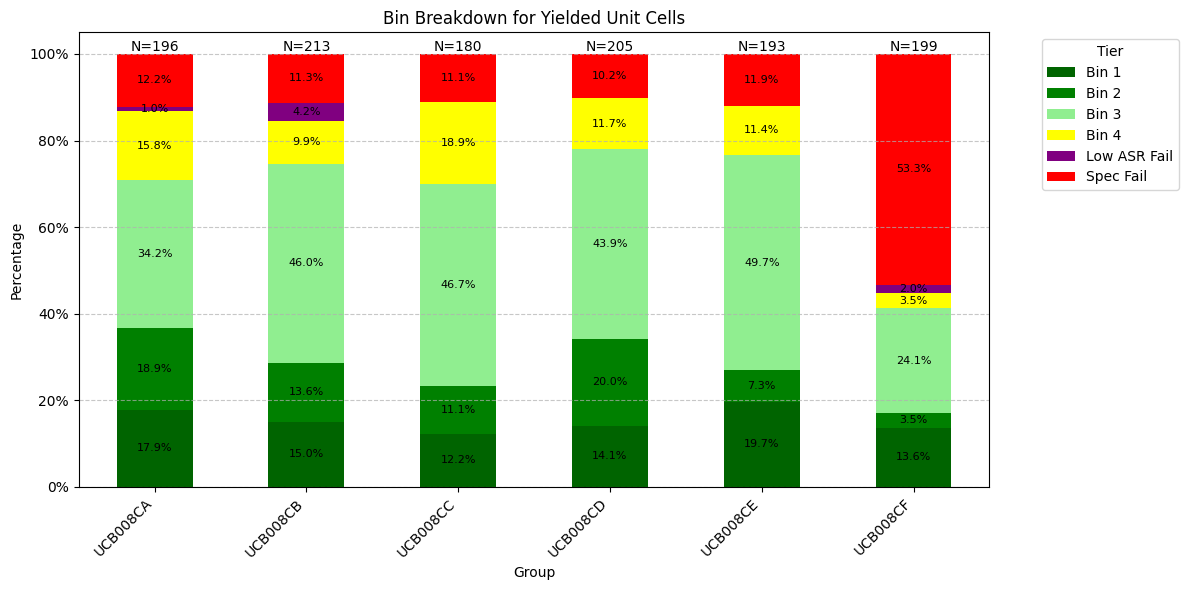

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Step 1: Filter out unwanted Tiers
excluded_tiers = ['Missing Matrix', 'Missing Matrix and TCDS', 'Missing TCDS']
filtered = CellTiers[~CellTiers['Tier'].isin(excluded_tiers)].copy()

# Step 2: Create group column
filtered['Batch'] = filtered['Cell ID'].str[:8]

# Step 3: Count occurrences
tier_counts = filtered.groupby(['Batch', 'Tier']).size().unstack(fill_value=0)

# Step 4: Normalize for proportions (as percentage)
tier_props = tier_counts.div(tier_counts.sum(axis=1), axis=0) * 100

# Step 5: Define custom named colors
tier_colors = {
    'Bin 1': 'darkgreen',
    'Bin 2': 'green',
    'Bin 3': 'lightgreen',
    'Bin 4': 'yellow',
    'Low ASR Fail': 'purple',
    'High ASR Fail': 'blue',
    'Spec Fail': 'red'
}

# Step 6: Match available tiers with color names
available_tiers = tier_props.columns.tolist()
colors = [tier_colors.get(tier, 'gray') for tier in available_tiers]

# Step 7: Plot
ax = tier_props[available_tiers].plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6), 
    color=colors
)

# Step 8: Add total counts on top
group_totals = tier_counts.sum(axis=1)
for i, total in enumerate(group_totals):
    ax.text(i, 100, f"N={total}", ha='center', va='bottom', fontsize=10)


# Step 9: Annotate individual values on bars
for bar_idx, (group, row) in enumerate(tier_props.iterrows()):
    cumulative_height = 0
    for tier in available_tiers:
        height = row[tier]
        if height > 0:
            ax.text(
                bar_idx, 
                cumulative_height + height / 2, 
                f"{height:.1f}%", 
                ha='center', va='center', fontsize=8, color='black'
            )
            cumulative_height += height

# Formatting
plt.ylabel('Percentage')
plt.xlabel('Group')
plt.title('Bin Breakdown for Yielded Unit Cells')
plt.legend(title='Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
plt.ylim(0, 105)
# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [117]:
import pandas as pd

from image_client.client import ImageClient
from image_client.manual_review import convert_manual_reviews_to_dataframe

img_client = ImageClient(host="image-api.qscape.app")

def get_ucspec_manual_tiers(samples: pd.Series) -> pd.DataFrame:
    """Get unit cell spec tiering determined by manual review.

    Args:
        samples: A series of unit cell sample IDs.

    Returns:
        A dataframe containing input sample IDs and manually-reviewed spec
        tiers for anode defects, edge wetting, and cathode-bead contact.
    """
    # Query manual review data
    samples = samples.to_list()
    manual_reviews = img_client.get_manual_reviews(samples=samples, include_history=False)
    manualreview_df = convert_manual_reviews_to_dataframe(manual_reviews, include_modified_date=False)


    return manualreview_df


get_ucspec_manual_tiers(pd.Series(['UCB008CC-US00-137']))

,min_c2f_distance,cathode_alignment_note,cathode_alignment,max_f2f_distance
sample_name,,,,
UCB008CC-US00-137,0.06,Narrow gap,1,0.326
